In [427]:
# LOAD PACKAGES
from scipy.spatial.transform import Rotation as R
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import math

In [428]:
# PREPARE DATA

# Load data
df = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

#list(df.columns)

# Convert timestamp from string to datetime

df['datetime_txt'] = df['Date'] + " " + df['Time hh:mm:ss.ddd']
df['datetime'] = pd.to_datetime(df['datetime_txt'], format = '%d/%m/%Y %H:%M:%S.%f')

gps['datetime_txt'] = gps['Date'] + " " + gps['Time']
gps['datetime'] = pd.to_datetime(gps['datetime_txt'], format = '%d/%m/%Y %H:%M:%S')

# Select Columns
df = df[['Acc_x',
        'Acc_y',
        'Acc_z',
        'Mag_x',
        'Mag_y',
        'Mag_z',
        'datetime']]

# Compute 1 second averages
df.set_index('datetime', inplace=True, drop = False)
df = df.resample('1s').mean()
df = df.reset_index(drop=True)
df['datetime'] = df['datetime'].dt.floor('s')

# Calculate elapsed time
df['elapsed_time'] = df['datetime'].diff().apply(lambda x: x.total_seconds())

# Merge GPS and activity data
df = pd.merge(df, gps, on='datetime', how='left')

df.head(10)

,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,location.lat,location.long,Height.above.msl,UTM_E,UTM_N,datetime_txt
0,-0.086304,-0.208716,-0.997119,-0.037402,0.071558,-0.270996,2019-02-25 22:24:00,NaN,25/02/2019,22:24:00,-26.167846,20.798018,914.0,479814.898495,7.105712e+06,25/02/2019 22:24:00
1,-0.038428,-0.173926,-1.043873,-0.006323,0.064746,-0.272217,2019-02-25 22:24:01,1.0,25/02/2019,22:24:01,-26.167847,20.798009,914.0,479813.999248,7.105712e+06,25/02/2019 22:24:01
2,0.041919,-0.208667,-1.012673,0.033252,0.066309,-0.263891,2019-02-25 22:24:02,1.0,25/02/2019,22:24:02,-26.167849,20.798000,914.0,479813.100174,7.105712e+06,25/02/2019 22:24:02
3,0.148633,-0.193091,-1.013867,0.047485,0.065674,-0.259741,2019-02-25 22:24:03,1.0,25/02/2019,22:24:03,-26.167850,20.797992,914.0,479812.300863,7.105712e+06,25/02/2019 22:24:03
4,0.161817,-0.191895,-1.016260,0.047217,0.066699,-0.260522,2019-02-25 22:24:04,1.0,25/02/2019,22:24:04,-26.167851,20.797985,914.0,479811.601487,7.105712e+06,25/02/2019 22:24:04
5,0.178711,-0.188306,-1.021023,0.049585,0.067017,-0.260059,2019-02-25 22:24:05,1.0,25/02/2019,22:24:05,-26.167852,20.797981,914.0,479811.201918,7.105712e+06,25/02/2019 22:24:05
6,0.165503,-0.190699,-1.021094,0.049951,0.068335,-0.259229,2019-02-25 22:24:06,1.0,25/02/2019,22:24:06,-26.167852,20.797981,914.0,479811.201918,7.105712e+06,25/02/2019 22:24:06
7,0.176319,-0.189502,-1.017479,0.050806,0.068579,-0.257300,2019-02-25 22:24:07,1.0,25/02/2019,22:24:07,-26.167851,20.797981,914.0,479811.201746,7.105712e+06,25/02/2019 22:24:07
8,0.188306,-0.185913,-1.022243,0.052832,0.068994,-0.258911,2019-02-25 22:24:08,1.0,25/02/2019,22:24:08,-26.167851,20.797981,914.0,479811.201746,7.105712e+06,25/02/2019 22:24:08
9,0.178736,-0.191895,-1.023440,0.055469,0.067676,-0.259644,2019-02-25 22:24:09,1.0,25/02/2019,22:24:09,-26.167851,20.797981,914.0,479811.201746,7.105712e+06,25/02/2019 22:24:09


## STEP 1: COMPUTE ACCELERATION COMPONENTS
Static acceleration is the acceleration component due to the pull of gravity. Following Shepard et al. 2008, static acceleration can be approximated using a moving average. According to Shepard et al. 2008, the length of the running mean should correspond to the point (or follow the point) where calculated overall dynamic body acceleration (ODBA) stabizes.


/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_24690/1842209085.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Gx'] = res['Acc_x'].rolling(window=win).mean()
/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_24690/1842209085.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Gy'] = res['Acc_y'].rolling(window=win).mean()
/var/folders/bp/jpzs1ydd4dj8jj8kv5fx8wq80000gn/T/ipykernel_24690/1842209085.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

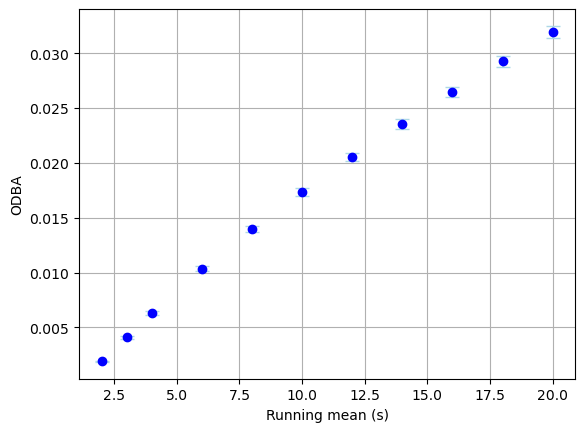

In [429]:
# WINDOW LENGTH SELECTION

# Possible window lengths
windows = [2,3,4,6,8,10,12,14,16,18,20]

# Set up dataframe to store results
acc_data = df[['Acc_x','Acc_y','Acc_z']]
window_results = pd.DataFrame(columns = ['Acc_x','Acc_y','Acc_z','Gx','Gy','Gz','DAx','DAy','DAz','ODBA','WindowLength'])

# Compute static acceleration using possible window lengths
for win in windows:
    # Get raw acceleration and set up results table
    res = acc_data
    # Compute static acceleration using rolling mean
    res['Gx'] = res['Acc_x'].rolling(window=win).mean()
    res['Gy'] = res['Acc_y'].rolling(window=win).mean()
    res['Gz'] = res['Acc_z'].rolling(window=win).mean()
    # Compute dynamic acceleration
    res['DAx'] = res['Acc_x'] - res['Gx']
    res['DAy'] = res['Acc_y'] - res['Gy']
    res['DAz'] = res['Acc_z'] - res['Gz']
    # Compute ODBA
    res['ODBA'] = res['DAx'] ** 2 + res['DAy'] ** 2 + res['DAz'] ** 2
    # Store Results
    res['WindowLength'] = [win]*len(res)
    res.head(10)
    window_results = pd.concat([window_results, res], ignore_index=True)

# Plot results
grouped = window_results.groupby('WindowLength')['ODBA']
means = grouped.mean()
std_errors = grouped.sem()
plt.errorbar(means.index, means, yerr=std_errors, fmt='o', color='blue', ecolor='lightblue', capsize=5)
plt.xlabel('Running mean (s)')
plt.ylabel('ODBA')
plt.grid(True)
plt.show()


In [430]:
# CALCULATE STATIC ACCELERATION
w = 10
df['Gx'] = df['Acc_x'].rolling(window=w).mean()
df['Gy'] = df['Acc_y'].rolling(window=w).mean()
df['Gz'] = df['Acc_z'].rolling(window=w).mean()

# Remove rows with NaN static accleration
df = df.iloc[w-1:].reset_index(drop=True)


In [431]:
# CALCULATE DYNAMIC ACCELERATION
df['DAx'] = df['Acc_x']-df['Gx']
df['DAy'] = df['Acc_y']-df['Gy']
df['DAz'] = df['Acc_z']-df['Gz']

In [432]:
# CALCULATE VeDBA
df['VeDBA']= (df['DAx']**2 + df['DAy']**2 + df['DAz']**2)**0.5

## STEP 2: COMPUTE PITCH AND ROLL
- Pitch = rotation about the lateral axis
- Roll = rotation about the anterior-posterior axis
- Yaw (heading) = rotation about the dorso-ventral axis.

In [433]:
# COMPUTE PITCH

# Function to compute roll
def calculate_pitch(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    pitch = math.atan2(gx,math.sqrt(gy**2 + gz**2))*180/math.pi
    return(pitch)

# Compute roll
df['pitch']=df.apply(calculate_pitch,axis=1)


In [434]:
# COMPUTE ROLL

# Function to compute roll
def calculate_roll(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    roll = math.atan2(gx,math.sqrt(gy**2 + gz**2))*180/math.pi
    return(roll)

# Compute roll
df['roll']=df.apply(calculate_roll,axis=1)

## STEP 3: CORRECT MAGNETOMETER DATA


In [435]:
# Filter for calibration events
# df_cal = df[df['Marked.event']==2]

# Calculate offsetts
# Ox = (df['Mag_x'].max() - df['Mag_x'].min())/2
# Oy = (df['Mag_y'].max() - df['Mag_y'].min())/2
# Oz = (df['Mag_z'].max() - df['Mag_z'].min())/2

# Correct Magnetometer Output
# df['Mx'] = df['Mag_x'] - Ox
# df['My'] = df['Mag_y'] - Oy
# df['Mz'] = df['Mag_z'] - Oz

## STEP 4: NORMALIZE COMPASS DATA

In [436]:
# Function to compute normalization factor
def calc_normalization_factor(row):
    Mx = row['Mag_x']
    My = row['Mag_y']
    Mz = row['Mag_z']
    fm = math.sqrt(Mx**2 + My**2 + Mz**2)
    return fm

# Compute normalization factor
df['fm'] = df.apply(calc_normalization_factor,axis=1)

# Normalize compass data
df['NMx'] = df['Mag_x']/df['fm']
df['NMy'] = df['Mag_y']/df['fm']
df['NMz'] = df['Mag_z']/df['fm']

## STEP 5: ROTATE AXES ACCORDING TO PITCH AND ROLL 

# Function to generate pitch rotation matrix
def get_rx(pitch):
    Rx = np.array([[1,0,0],
          [0,math.cos(pitch),-math.sin(pitch)],
          [0,math.sin(pitch),math.cos(pitch)]])
    return Rx

# Function to generate roll rotation matrix
def get_ry(roll):
    Ry = np.array([[math.cos(roll),0,math.sin(roll)],
         [0,1,0],
         [-math.sin(roll),0,math.cos(roll)]])
    return Ry


# Function to generate yaw rotation matrix
def get_rz(yaw):
    Rz = np.array([[math.cos(yaw), -math.sin(yaw),0],
                 [math.sin(yaw), math.cos(yaw), 0],
                 [0,0,1]])
    return Rz

# Function to rotate axes by pitch and roll
def rotate_axes(row):
    NMx = row['NMx']
    NMy = row['NMy']
    NMz = row['NMz']
    NM = np.array([NMx,NMy,NMz])
    
    pitch = row['pitch']
    Rx = get_rx(pitch = pitch)
    
    roll = row['roll']
    Ry = get_ry(roll = roll)
    
    RNM = np.dot(NM,np.dot(Rx,Ry))

    row['RNMx'] = RNM[0]
    row['RNMy'] = RNM[1]
    return(row)

# Rotate axes of magnetometer output
df['RNMx'] = -999
df['RNMy'] = -999
df = df.apply(rotate_axes,axis=1)

## STEP 5: DERIVE HEADING

In [437]:
# Function to derive heading
def get_heading(row):
    NMx = row['NMx']
    NMy = row['NMy']
    NMz = row['NMz']
    pitch = row['pitch']
    roll = row['roll']
    yaw = np.arctan2(
    NMx * np.cos(roll) - NMz * np.sin(roll),
    NMx * np.cos(pitch) + NMy * np.sin(pitch) * np.sin(roll) + NMz * np.sin(pitch) * np.cos(roll)
    )
    return yaw

# Calculate heading
df['yaw'] = df.apply(get_heading,axis = 1)

## STEP 6: CALCULATE SPEED FROM VEDBA

In [438]:
# Initialize constants with nominal values
# These will be changed later on when aligning dead-reckoned trajectories with GPS

m = 5
c = 0.1
df['m'] = m # constant of proportionality
df['c'] = c # constant

# Calculate speed (speed = (m*VeDBA)+c
df['s'] = m*df['VeDBA'] + c

# Calculate distance (distance = speed * time)
df['d'] = df['s'] * df['elapsed_time']
df.head(10)


,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,...,roll,fm,NMx,NMy,NMz,yaw,m,c,s,d
0,0.178736,-0.191895,-1.023440,0.055469,0.067676,-0.259644,2019-02-25 22:24:09,1.0,25/02/2019,22:24:09,...,6.138781,0.273992,0.202447,0.246999,-0.947632,0.185767,5,0.1,0.436841,0.436841
1,0.189478,-0.189502,-1.023487,0.057129,0.067090,-0.258252,2019-02-25 22:24:10,1.0,25/02/2019,22:24:10,...,7.624402,0.272872,0.209362,0.245866,-0.946424,1.497619,5,0.1,0.352114,0.352114
2,0.182300,-0.188306,-1.010278,0.062183,0.065405,-0.257812,2019-02-25 22:24:11,1.0,25/02/2019,22:24:11,...,8.841972,0.273152,0.227649,0.239447,-0.943844,0.805877,5,0.1,0.214121,0.214121
3,0.194287,-0.184717,-1.015016,0.077222,0.057056,-0.253369,2019-02-25 22:24:12,1.0,25/02/2019,22:24:12,...,9.664698,0.270951,0.285002,0.210575,-0.935111,-2.337566,5,0.1,0.193939,0.193939
4,0.189502,-0.195484,-1.001856,0.079932,0.054590,-0.251123,2019-02-25 22:24:13,1.0,25/02/2019,22:24:13,...,9.894881,0.269132,0.296998,0.202837,-0.933086,-2.288357,5,0.1,0.193735,0.193735
5,0.190699,-0.196680,-1.006617,0.081909,0.053735,-0.250024,2019-02-25 22:24:14,1.0,25/02/2019,22:24:14,...,10.058201,0.268531,0.305027,0.200109,-0.931083,-2.231904,5,0.1,0.168857,0.168857
6,0.200269,-0.199072,-1.016284,0.084253,0.052563,-0.249024,2019-02-25 22:24:15,1.0,25/02/2019,22:24:15,...,10.176557,0.268094,0.314267,0.196064,-0.928868,-2.178998,5,0.1,0.183595,0.183595
7,0.196680,-0.201489,-1.009032,0.085132,0.052539,-0.249072,2019-02-25 22:24:16,1.0,25/02/2019,22:24:16,...,10.353547,0.268412,0.317169,0.195741,-0.927949,-2.070507,5,0.1,0.167141,0.167141
8,0.202661,-0.199072,-1.006665,0.083789,0.052344,-0.248804,2019-02-25 22:24:17,1.0,25/02/2019,22:24:17,...,10.503712,0.267701,0.312995,0.195531,-0.929409,-1.947709,5,0.1,0.172490,0.172490
9,0.205053,-0.196680,-1.012647,0.082886,0.054736,-0.251929,2019-02-25 22:24:18,1.0,25/02/2019,22:24:18,...,10.601032,0.270803,0.306074,0.202126,-0.930303,-1.845795,5,0.1,0.161608,0.161608


## STEP 7: PERFORM DEAD RECKONING CALCULATION

In [439]:
# Start dead reckoning from first GPS fix and filter for first 10 rows
df = df.iloc[:10]

# Row ID column
df['rowID'] = range(0,len(df))

In [440]:
# Initialize the transformation matrix
transformation_matrix = np.eye(4)
transformation_matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [441]:
# Initialize position
position = np.array([[0],[0],[0]])
utm_x = df.loc[0,'UTM_E']
utm_y = df.loc[0,'UTM_N']

# Initialize columns for dead-reckoned coordinates
df['DR_x'] = -999.0
df.loc[0,'DR_x'] = 0
df['DR_y'] = -999.0
df.loc[0,'DR_y'] = 0
df['DR_z'] = -999.0
df.loc[0,'DR_z'] = -999.0
df['DR_utm_x'] = -999.0
df.loc[0,'DR_utm_x'] = df.loc[0,'UTM_E']
df['DR_utm_y'] = -999.0
df['DR_utm_y'] = df.loc[0,'UTM_N']

In [442]:
# Initialize error column
#df['error']

In [443]:
# Perform dead reckoning

for i in range(len(df)-1 ):

    global transformation_matrix

    global position
        
    # Construct the rotation matrix
    pitch = df.loc[i,'pitch']
    roll = df.loc[i,'roll']
    yaw = df.loc[i,'yaw']
    Rx = get_rx(pitch)
    Ry = get_ry(roll)
    Rz = get_rz(yaw)
    rotation_matrix = Rx @ Ry @ Rz

    # Compute the displacement vector
    initial_direction = np.array([[1],[0],[0]])
    direction_vector = rotation_matrix @ initial_direction
    distance = df.loc[i,'d']
    displacement_vector = direction_vector * distance
        
    #update homo_trans_step
    transformation_step = np.append(np.append(rotation_matrix, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
    transformation_step[:3,-1] = displacement_vector.flatten()

    #update overall transform
    transformation_matrix = transformation_matrix @ transformation_step

    # Update coordinates
    current_position = position
    next_position = current_position + displacement_vector
    df.loc[i+1,'DR_x'] = next_position[0]
    df.loc[i+1,'DR_utm_x'] = displacement_vector[0] + df.loc[i,'DR_utm_x']
    df.loc[i+1,'DR_y'] = next_position[1]
    df.loc[i+1,'DR_utm_y'] = displacement_vector[1] + df.loc[i,'DR_utm_y']
    df.loc[i+1,'DR_z'] = next_position[2]
    position = next_position


In [444]:
df.head(10)

,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,...,m,c,s,d,rowID,DR_x,DR_y,DR_z,DR_utm_x,DR_utm_y
0,0.178736,-0.191895,-1.023440,0.055469,0.067676,-0.259644,2019-02-25 22:24:09,1.0,25/02/2019,22:24:09,...,5,0.1,0.436841,0.436841,0,0.000000,0.000000,-999.000000,479811.201746,7.105712e+06
1,0.189478,-0.189502,-1.023487,0.057129,0.067090,-0.258252,2019-02-25 22:24:10,1.0,25/02/2019,22:24:10,...,5,0.1,0.352114,0.352114,1,0.424856,0.088735,0.049527,479811.626602,7.105712e+06
2,0.182300,-0.188306,-1.010278,0.062183,0.065405,-0.257812,2019-02-25 22:24:11,1.0,25/02/2019,22:24:11,...,5,0.1,0.214121,0.214121,2,0.430715,0.193061,0.385780,479811.632461,7.105712e+06
3,0.194287,-0.184717,-1.015016,0.077222,0.057056,-0.253369,2019-02-25 22:24:12,1.0,25/02/2019,22:24:12,...,5,0.1,0.193939,0.193939,3,0.306917,0.109000,0.538933,479811.508663,7.105712e+06
4,0.189502,-0.195484,-1.001856,0.079932,0.054590,-0.251123,2019-02-25 22:24:13,1.0,25/02/2019,22:24:13,...,5,0.1,0.193735,0.193735,4,0.437620,0.237067,0.603179,479811.639366,7.105712e+06
5,0.190699,-0.196680,-1.006617,0.081909,0.053735,-0.250024,2019-02-25 22:24:14,1.0,25/02/2019,22:24:14,...,5,0.1,0.168857,0.168857,5,0.551191,0.341057,0.720742,479811.752937,7.105712e+06
6,0.200269,-0.199072,-1.016284,0.084253,0.052563,-0.249024,2019-02-25 22:24:15,1.0,25/02/2019,22:24:15,...,5,0.1,0.183595,0.183595,6,0.634756,0.412159,0.849094,479811.836502,7.105712e+06
7,0.196680,-0.201489,-1.009032,0.085132,0.052539,-0.249072,2019-02-25 22:24:16,1.0,25/02/2019,22:24:16,...,5,0.1,0.167141,0.167141,7,0.711386,0.473293,1.004328,479811.913132,7.105712e+06
8,0.202661,-0.199072,-1.006665,0.083789,0.052344,-0.248804,2019-02-25 22:24:17,1.0,25/02/2019,22:24:17,...,5,0.1,0.172490,0.172490,8,0.759345,0.509771,1.160230,479811.961091,7.105712e+06
9,0.205053,-0.196680,-1.012647,0.082886,0.054736,-0.251929,2019-02-25 22:24:18,1.0,25/02/2019,22:24:18,...,5,0.1,0.161608,0.161608,9,0.789327,0.536189,1.328028,479811.991073,7.105712e+06


## VISUALIZE RESULTS

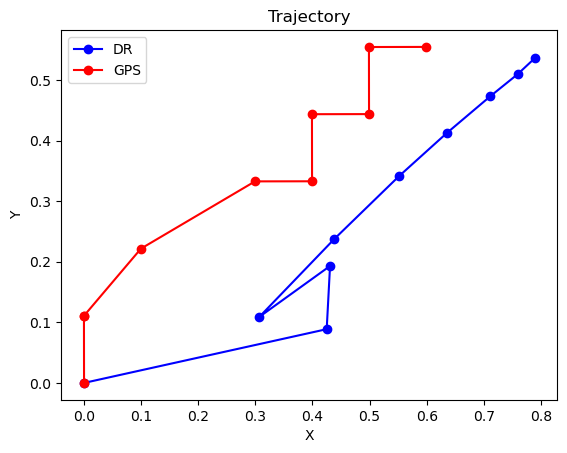

In [445]:
# Plot dead reckoned vs GPS trajectory

dr_x = df['DR_x']
dr_y = df['DR_y']
utm_x = df['UTM_E'] - df.loc[0,'UTM_E']
utm_y = df['UTM_N'] - df.loc[0,'UTM_N']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dr_x,dr_y, marker='o', linestyle='-', color='b', label='DR')
ax.plot(utm_x,utm_y, marker='o', linestyle='-', color='r', label='GPS')

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()

In [446]:
def draw_frame(fig, homo_trans, alpha = 1.):
    """fig = plotly figure object
       homo_trans = homogenous transformation matrix (4x4)"""

    x0 = homo_trans[0,3]
    y0 = homo_trans[1,3]
    z0 = homo_trans[2,3]
    x1, y1, z1 =  np.eye(3) @ homo_trans[:3,:3]
    x1 += homo_trans[0,-1]
    y1 += homo_trans[1,-1]
    z1 += homo_trans[2,-1]
    fig.add_trace(go.Scatter3d(x=[x0, x1[0]], y=[y0, y1[0]], z=[z0, z1[0]], mode='lines', line=dict(color='rgba(255, 0, 0, ' +str(alpha) + ')', width=5)))
    fig.add_trace(go.Scatter3d(x=[x0, x1[1]], y=[y0, y1[1]], z=[z0, z1[1]], mode='lines', line=dict(color='rgba(0, 255, 0, ' +str(alpha) + ')', width=5)))
    fig.add_trace(go.Scatter3d(x=[x0, x1[2]], y=[y0, y1[2]], z=[z0, z1[2]], mode='lines', line=dict(color='rgba(0, 0, 255, ' +str(alpha) + ')', width=5)))

In [447]:
def get_translation_vector(heading,speed):
    # Convert heading to radians
    angle_radians = heading * math.pi/180 
    # Calculate the components
    vx = speed * math.cos(angle_radians)
    vy = speed * math.sin(angle_radians)
    # make vector
    v = np.array([vx,vy,0])
    return v

In [448]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [449]:
# Create a 3D figure
fig = go.Figure()
fig.update_layout(
    scene=dict(
        aspectmode='data'  # ensures all axes are scaled equally
    )
)

#initialize 3x3 rotation matrix
#euler_angles = [0.,0.,0.] #rotation about xaxis, yaxis, zaxis
# print("\n rotation matrix (3x3) \n", rotm, "\n")

#initialize translation vector
trans_vec = np.array([[0., 0., 0]]) #[x, y, z]
# print("\n translation vector (3x1) \n", trans_vec)

#resize rotation matrix to 4x4 so it can be used with homogenous cooridnates
#update homo_trans to include translation as well
#print("\n homogenous transformation matrix (4x4) for pose 0 \n", homo_trans ,"\n")


runLen = len(df)

draw_frame(fig, np.eye(4), alpha = 1/runLen)
homo_trans = np.eye(4)

for i in range(runLen):
    if i%50 == 0:
        plot = True
    else:
        plot = False
    i = i + 9
    row = df[df['rowID']==i]

    #update translation
    row_label = row.index[0]
    heading = row.at[row_label,'H']
    speed = row.at[row_label,'s']
    new_trans_step = get_translation_vector(heading = heading, speed = speed)
    
    #update rotation
    pitch = row['pitch']
    Rx = get_rx(pitch = pitch)
    
    roll = row['roll']
    Ry = get_ry(roll = roll)

    yaw = roll['H']
    Rz = get_rz(
    
    new_rotm_step = Rx @ Ry
    
    #update homo_trans_step
    homo_trans_step = np.append(np.append(new_rotm_step, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
    homo_trans_step[:3,-1] = new_trans_step
    
    
    #update overall transform
    homo_trans = homo_trans @ homo_trans_step
    
#     print("\n overall homogenous transformation matrix (4x4) for pose", i + 1, "\n", homo_trans ,"\n")
#     print("\n just since the last frame \n", homo_trans_step, "\n")
    
    #add to figure
    if plot == True:
        draw_frame(fig, homo_trans, (i+1)/(runLen+1))


fig.show()

SyntaxError: '(' was never closed (730087770.py, line 49)

In [ ]:
df.colnames()

In [ ]:
df[df['rowID']] == 1

In [ ]:
df.at[53,'H']